# AMATH 584 HW # 2 Code
Author: Marlin Figgins
Date: Oct. 21, 2020.

I decided to use Julia for this homework assignment! Don't know if you're familar with it, but I will document the code thoroughly and especially for anything that deviate significantly from Python and Matlab

In [25]:
# Load packages
using LinearAlgebra # Contains functions for SVD and dealing with matrix factorizations
using Plots # General plotting libray
using Images, Colors # Handling Images
using LaTeXStrings # Latex in plots

# Cropped data set

## Loading and Resizing Data

In [49]:
# Use readdir to get file names
CroppedDataDir = "../data/CroppedYale/"
YaleFolders = readdir(CroppedDataDir)[occursin.("yale", readdir(CroppedDataDir))]

# Loop over folders and read images
img_array = []
for folder in YaleFolders
    FolderDir = CroppedDataDir * folder
    FileNames = readdir(FolderDir)
    for file in FileNames 
        if occursin("pgm", file)
            push!(img_array, load(CroppedDataDir * folder * "/" * file))
        end
    end
end

In [50]:
# Save image sizes for conversion to image later
m,n = size(img_array[1])
test_img_vec = vec(img_array[1]);

In [51]:
# Covert greyscale images to column vector
img_array = vec.(img_array);

In [52]:
# Assigning 70% of data to 'train' set for the SVD
train_length = trunc(Int,0.7*length(img_array))

# Combine column vectors of training set to matrix.
#Here, each column corresponds to an observation or individual face.
X_train = hcat(img_array[1:train_length]...);

# Combining remaining columnb vectors to test matrix
X_test = hcat(img_array[(train_length+1):end]...);

# Computing the SVD

In [53]:
# Compute the SVD of the matrix
U, S, V = F = svd(X_train);

In [54]:
# Helper functions

# Convert column vector to face matrix
function vec_to_face(v, m,n)
    return reshape(v,m,n) 
end

# Project face into U space
function project_face(F::SVD, v, r)
    # F.U is the matrix U under the SVD
    new_v = F.U[:,1:r]*(F.U[:, 1:r]' * v)
    return new_v
end

# Recover basis coefficients in U space
function project_alpha(F::SVD, v, r)
    # F.U is the matrix U under the SVD
    new_alpha = F.U[:, 1:r]' * v
    return new_alpha
end

# Rank approximation
function rank_approx(F::SVD, r)
    U, S, V = F
    M = U[:, 1:r] * Diagonal(S[1:r]) * V[:, 1:r]'
end;

# Find corresponding ranks for vector of precent thresholds
function rank_threshold(F::SVD, percent_thres)
    percent_energy = cumsum(F.S)/sum(F.S)
    r_thres = []
    for thres in percent_thres
        push!(r_thres, findfirst( percent_energy .> thres) )
    end
    return r_thres
end

rank_threshold (generic function with 1 method)

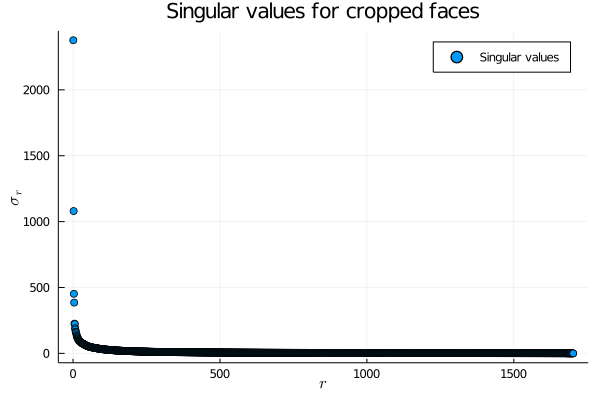

In [55]:
# Plot singular value fall off
scatter(S,
    xlabel = L"r",
    ylabel = L"\sigma_r",
    label = "Singular values",
    title = "Singular values for cropped faces")
savefig("../figures/hw-2-cropped-singular-values.pdf")

In [56]:
# Visualizing top 20 eigenfaces
r = 20

P = [] # List of plots
for i in 1:r
    Face = vec_to_face(U[:,i], m, n)
    push!(P, heatmap(Face, color = :greys, yflip=true, axis = nothing, legend=false))
end
plot(P[:]..., layout = (5,4), size = (600, 800))
savefig("../figures/hw-2-cropped-eigenfaces.pdf")

## Rank approximation

In [57]:
r = [5, 10, 50, 100, 200, 400, 1000, 1500] # Vector of ranks used to approximate test face

# Extracting and plotting test face
test_face = 5 # Test index
real_face = vec_to_face(X_test[:, test_face], m, n) 
real_plot = heatmap(real_face, color = :greys, yflip=true, axis = nothing, legend=false, title="Original image")

# Approximating this face at various ranks 
rankr_approx = []
for rank in r
    # Project face into U space with rank r
    proj = project_face(F, X_test[:, test_face], rank)
    proj_face = vec_to_face(proj, m, n)
    
    # Adding to approximation to plot
    push!(rankr_approx, heatmap(proj_face, color = :greys, yflip=true, axis = nothing, legend=false, title="r= $(rank) approximation"))
end

plot(real_plot, rankr_approx..., layout = 1 + length(r), size = (800, 1000))
savefig("../figures/hw-2-cropped-rank-approximation.pdf")

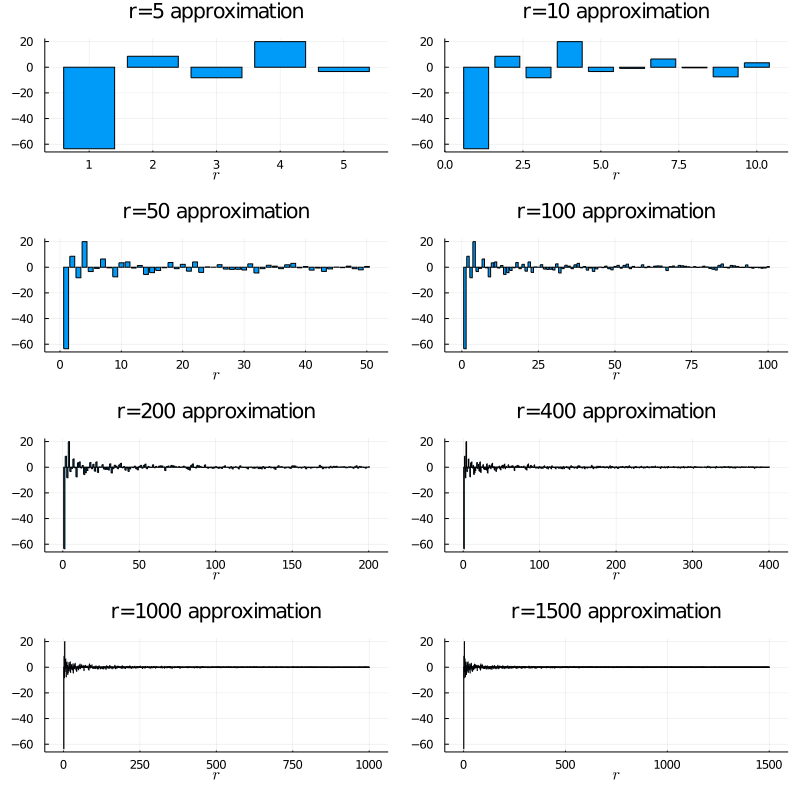

In [58]:
# Visualizing weights
rankr_weights = []
for rank in r
    # Project face into U space with rank r
    proj_alpha = convert.(Float64, project_alpha(F, X_test[:, test_face], rank))
    
    # Adding to approximation to plot
    push!(rankr_weights, bar(proj_alpha, label=false, title="r=$(rank) approximation",xlabel = L"r"))
end


plot(rankr_weights..., layout = (4, 2), size = (800, 800))
savefig("../figures/hw-2-cropped-rank-weights.pdf")

## Choosing approximation rank with hard threshold

In [59]:
# Percent of spectrum described by modes
percent_energy = cumsum(S)/sum(S)

plot(percent_energy, 
    xlabel = L"\textrm{Rank } r", 
    ylabel = L"\textrm{Percentage of total energy}",
    legend=false);

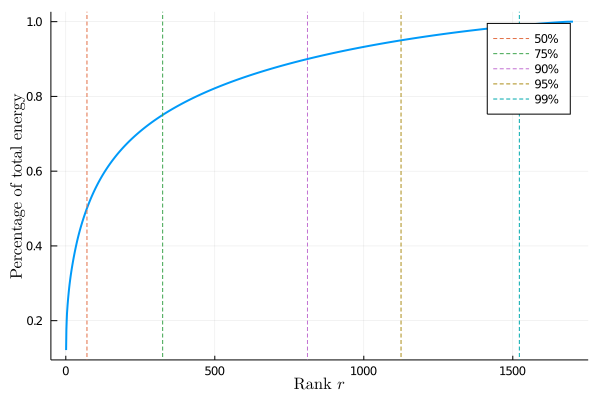

In [60]:
# We can use the cummulative sum of the energy to put a threshold on the rank r.

percent_thres = [0.50 0.75 0.90 0.95 0.99]

# Finds the minimal rank r for which total energy is less than threshold
r_thres = []
for thres in percent_thres
    push!(r_thres, findfirst( percent_energy .> thres) )
end

# Plotting location on previous plot
plot(percent_energy, 
    linewidth = 2,
    xlabel = L"\textrm{Rank } r", 
    ylabel = L"\textrm{Percentage of total energy}",
    label = false)

for k in eachindex(r_thres)
    vline!( [r_thres[k]], 
        label="$(Int(percent_thres[k]*100))%",
        style=:dash)
end

plot!()
savefig("../figures/hw-2-cropped-percent-energy-thresholds.pdf")

In [61]:
# Approximating this face at threshold ranks
rankr_approx = []
for k in eachindex(r_thres)
    # Project face into U space with rank r
    proj = project_face(F, X_test[:, test_face], r_thres[k])
    proj_face = vec_to_face(proj, m, n)
    
    # Adding to approximation to plot
    push!(rankr_approx, heatmap(proj_face, 
                                color = :greys, 
                                yflip=true, 
                                axis = nothing, 
                                legend=false, 
                                title="$(Int(percent_thres[k]*100))% energy threshold"))
end

plot(real_plot, rankr_approx..., layout = 1 + length(r_thres), size = (800, 700))
savefig("../figures/hw-2-cropped-percent-energy-approximation.pdf")

# Uncropped faces

In [62]:
# Use readdir to get file names
UncroppedDataDir = "../data/yalefaces_uncropped/"
YaleFolders = readdir(UncroppedDataDir)[occursin.("yale", readdir(UncroppedDataDir))]

# Loop over folders and read images
u_img_array = []
for folder in YaleFolders
    FolderDir = UncroppedDataDir * folder
    FileNames = readdir(FolderDir)
    for file in FileNames 
        if occursin("subject", file)
            push!(u_img_array, Gray.(load(UncroppedDataDir * folder * "/" * file)))
        end
    end
end

In [63]:
# Save image sizes for conversion to image later
m,n = size(u_img_array[1])

(243, 320)

In [64]:
# Covert greyscale images to column vector
u_img_array = vec.(u_img_array);

In [65]:
# Assigning 80% of data to 'train' set for the SVD
train_length = trunc(Int,0.8*length(u_img_array))

# Combine column vectors of training set to matrix.
#Here, each column corresponds to an observation or individual face.
X_train = hcat(u_img_array[1:train_length]...);

# Combining remaining columnb vectors to test matrix
X_test = hcat(u_img_array[(train_length+1):end]...);

In [66]:
# Compute the SVD of the matrix
U, S, V = F = svd(X_train);

In [67]:
# Visualizing top 20 eigenfaces
r = 20

P = [] # List of plots
for i in 1:r
    Face = vec_to_face(U[:,i], m, n)
    push!(P, heatmap(Face, color = :greys, yflip=true, axis = nothing, legend=false))
end
plot(P[:]..., layout = (5,4), size = (800, 1000))
savefig("../figures/hw-2-uncropped-eigenfaces.pdf")

In [68]:
# Plot singular value fall off
scatter(S,
    xlabel = L"r",
    ylabel = L"\sigma_r",
    label = "Singular values",
    title = "Singular values for uncropped faces")
savefig("../figures/hw-2-uncropped-singular-values.pdf")

In [69]:
r = [5, 10, 50, 100, length(S)] # Vector of ranks used to approximate test face

# Extracting and plotting test face
test_face = 5 # Test index
real_face = vec_to_face(X_test[:, test_face], m, n) 
real_plot = heatmap(real_face, color = :greys, yflip=true, axis = nothing, legend=false, title="Original image")

# Approximating this face at various ranks 
rankr_approx = []
for rank in r
    # Project face into U space with rank r
    proj = project_face(F, X_test[:, test_face], rank)
    proj_face = vec_to_face(proj, m, n)
    
    # Adding to approximation to plot
    push!(rankr_approx, heatmap(proj_face, color = :greys, yflip=true, axis = nothing, legend=false, title="r= $(rank) approximation"))
end

plot(real_plot, rankr_approx..., layout = 1 + length(r), size = (800, 800))
savefig("../figures/hw-2-uncropped-rank-approximation.pdf")

In [70]:
# Percent energy thresholding on uncropped data
percent_energy = cumsum(S)/sum(S)
percent_thres = [0.50 0.75 0.90 0.95 0.99]

# Finds the minimal rank r for which total energy is less than threshold
r_thres = []
for thres in percent_thres
    push!(r_thres, findfirst( percent_energy .> thres) )
end

# Plotting location on previous plot
plot(percent_energy, 
    linewidth = 2,
    xlabel = L"\textrm{Rank } r", 
    ylabel = L"\textrm{Percentage of total energy}",
    label = false)

for k in eachindex(r_thres)
    vline!( [r_thres[k]], 
        label="$(Int(percent_thres[k]*100))%",
        style=:dash)
end

plot!()
savefig("../figures/hw-2-uncropped-percent-energy-thresholds.pdf")

In [71]:
# Approximating this face at threshold ranks
rankr_approx = []
for k in eachindex(r_thres)
    # Project face into U space with rank r
    proj = project_face(F, X_test[:, test_face], r_thres[k])
    proj_face = vec_to_face(proj, m, n)
    
    # Adding to approximation to plot
    push!(rankr_approx, heatmap(proj_face, 
                                color = :greys, 
                                yflip=true, 
                                axis = nothing, 
                                legend=false, 
                                title="$(Int(percent_thres[k]*100))% energy threshold"))
end

plot(real_plot, rankr_approx..., layout = 1 + length(r_thres), size = (800, 700))
savefig("../figures/hw-2-uncropped-percent-energy-approximation.pdf")